In [78]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import resnet18,ResNet18_Weights
import os
import glob
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt


In [79]:
class ApplesTomatoesDataset(Dataset):
    def __init__(self, root_dir, image_size=224):
        self.root_dir = root_dir
        self.image_size = image_size

        self.transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        self.data = []
        self.labels = []

        self.classes = ['apples', 'tomatoes']

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            image_paths = glob.glob(os.path.join(class_dir, '*.*'))
            image_paths = [p for p in image_paths if p.lower().endswith(('.jpg', '.jpeg', '.png'))]

            print(f"[DEBUG] {class_name} - ditemukan {len(image_paths)} file")

            self.data.extend(image_paths)
            self.labels.extend([label] * len(image_paths))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)
        return image, label


In [80]:
batch_size = 32
test_batch_size = 32
train_dataset = ApplesTomatoesDataset(root_dir='/kaggle/input/tomatoapple/train')
test_dataset  = ApplesTomatoesDataset(root_dir='/kaggle/input/tomatoapple/test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_dataset))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

[DEBUG] apples - ditemukan 164 file
[DEBUG] tomatoes - ditemukan 130 file
[DEBUG] apples - ditemukan 54 file
[DEBUG] tomatoes - ditemukan 43 file


In [81]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params / 1e6:.2f}M")
print(f"Trainable parameters: {trainable_params / 1e6:.2f}M")

Total parameters: 11.33M
Trainable parameters: 11.33M


In [82]:
num_epoch = 10
train_losses = []
test_losses = []

for epoch in range(num_epoch):
	model.train()

	train_loss = 0

	for data, labels in tqdm(train_loader):

		data, labels = data.to(device), labels.to(device)
		bs = data.size()[0]
		optimizer.zero_grad()

		outputs = model(data)
		loss = criterion(outputs, labels)

		loss.backward()

		optimizer.step()

		train_loss += loss.item() * data.size(0)

	model.eval()

	correct = 0
	total = 0
	test_loss = 0

	with torch.no_grad():
		for data, labels in tqdm(test_loader):
			data, labels = data.to(device), labels.to(device)
			bs = data.size()[0]
			outputs = model(data)

			loss = criterion(outputs, labels)
			test_loss += loss.item() * data.size(0)

			_, preds = torch.max(outputs, 1)
			correct += (preds == labels).sum().item()

			total += labels.size(0)

	acc = correct / total
	avg_train_loss = train_loss / len(train_dataset)
	avg_test_loss = test_loss / len(test_dataset)

	train_losses.append(avg_train_loss)
	test_losses.append(avg_test_loss)

	print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.4f}, Test Loss {avg_test_loss:.4f}, Test Acc {acc:.4f}")


100%|██████████| 4/4 [00:00<00:00,  9.85it/s]


Epoch 1: Train Loss 4.2790, Test Loss 2.4353, Test Acc 0.7732


100%|██████████| 4/4 [00:00<00:00, 13.32it/s]


Epoch 2: Train Loss 1.6409, Test Loss 1.1801, Test Acc 0.9278


100%|██████████| 4/4 [00:00<00:00, 12.28it/s]


Epoch 3: Train Loss 0.5561, Test Loss 0.8137, Test Acc 0.9588


100%|██████████| 4/4 [00:00<00:00, 11.11it/s]


Epoch 4: Train Loss 0.2327, Test Loss 0.6397, Test Acc 0.9485


100%|██████████| 4/4 [00:00<00:00, 12.02it/s]


Epoch 5: Train Loss 0.1376, Test Loss 0.4780, Test Acc 0.9485


100%|██████████| 4/4 [00:00<00:00, 12.79it/s]


Epoch 6: Train Loss 0.0684, Test Loss 0.4103, Test Acc 0.9588


100%|██████████| 4/4 [00:00<00:00, 13.57it/s]


Epoch 7: Train Loss 0.0458, Test Loss 0.3564, Test Acc 0.9588


100%|██████████| 4/4 [00:00<00:00, 13.01it/s]


Epoch 8: Train Loss 0.0382, Test Loss 0.3381, Test Acc 0.9588


100%|██████████| 4/4 [00:00<00:00, 12.96it/s]


Epoch 9: Train Loss 0.0274, Test Loss 0.2760, Test Acc 0.9691


100%|██████████| 4/4 [00:00<00:00,  5.25it/s]

Epoch 10: Train Loss 0.0999, Test Loss 0.2788, Test Acc 0.9485


In [83]:
torch.save({
    'epoch': num_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_losses,
    'test_loss': test_losses,
}, 'apples_tomatoes_checkpoint.pth')

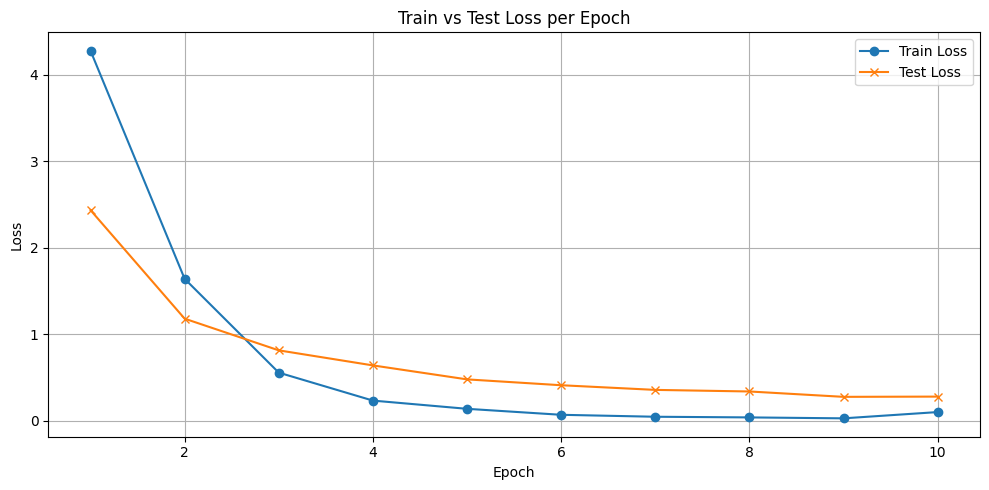

In [84]:
epochs = range(1, num_epoch + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [85]:
def load_model(weight_path, num_classes, device):
    checkpoint = torch.load(weight_path, map_location=device)

    model = resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, checkpoint['model_state_dict']['fc.weight'].size(0))  # fix

    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    return model

In [86]:
def predict_image(image_path, model, device, class_names):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, pred = torch.max(outputs, 1)

    predicted_class = class_names[pred.item()]
    return predicted_class, image

Prediction: apples


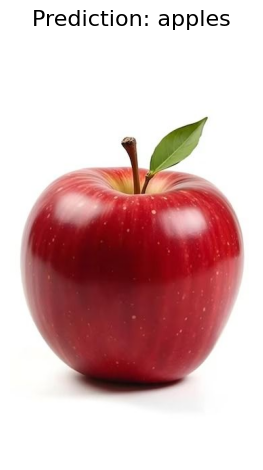

In [87]:
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Gantilah dengan label sesuai urutan di dataset ImageFolder
    class_names = ['apples', 'tomatoes']

    # Load model
    model = load_model('apples_tomatoes_checkpoint.pth', num_classes=len(class_names), device=device)

    # Ganti path gambar sesuai kebutuhan
    img_path = '/kaggle/input/train-apple-tomato/Apple Photos - Download Free High-Quality Pictures _ Freepik.jpg'
    predicted_label, image = predict_image(img_path, model, device, class_names)

    print(f"Prediction: {predicted_label}")
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_label}", fontsize=16)
    plt.tight_layout()
    plt.show()

Prediction: tomatoes


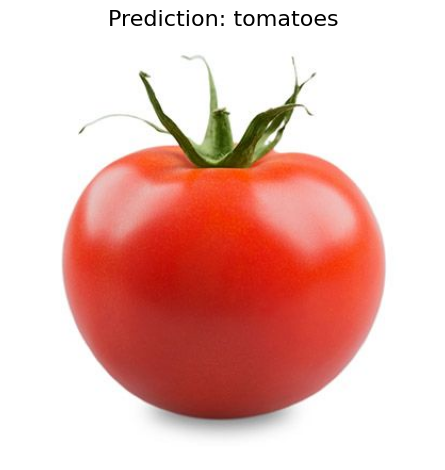

In [88]:
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Gantilah dengan label sesuai urutan di dataset ImageFolder
    class_names = ['apples', 'tomatoes']

    # Load model
    model = load_model('apples_tomatoes_checkpoint.pth', num_classes=len(class_names), device=device)

    # Ganti path gambar sesuai kebutuhan
    img_path = '/kaggle/input/train-apple-tomato/5 tips for planting your own tomatoes - Atlanta Magazine.jpg'
    predicted_label, image = predict_image(img_path, model, device, class_names)

    print(f"Prediction: {predicted_label}")
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_label}", fontsize=16)
    plt.tight_layout()
    plt.show()